In [22]:
import sys
sys.path.append("../")

import torch

from tdoa.visualization import plot_mics_and_sources
from neural_tdoa.model import TdoaCrnn
from neural_tdoa.utils.load_config import load_config
from datasets.dataset import TdoaDataset
from datasets.visualization import plot_microphone_signals


def load_model():
    model = TdoaCrnn()
    
    weights = torch.load("../tests/fixtures/weights.ckpt",
                         map_location=torch.device('cpu'))["state_dict"]
    weights = {
        k.replace("model.", ""): v for k, v in weights.items()
    }
    
    model.load_state_dict(weights)
    model.eval()

    return model

def eval_model(model, x):
    with torch.no_grad():
        return model(x, normalized=False)

model = load_model()
config = load_config()
dataset = TdoaDataset(config["test_dataset"])

  0%|                                                                                                 | 0/500 [00:00<?, ?it/s]

dataset directory does not exist. Generating new dataset


100%|███████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:29<00:00,  1.85it/s]


No handles with labels found to put in legend.


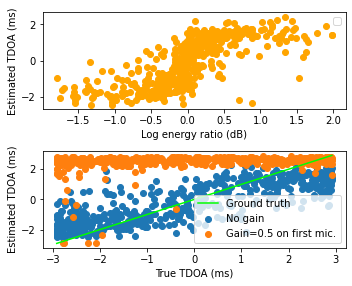

In [42]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm, trange

eps = np.finfo(np.float32).eps


def error(y_gt, y_pred):
    return np.sqrt((y_gt - y_pred)**2)

    
def eval_dataset(model, dataset, sort=True, plot_results=True):

    output_dicts = []
    
    for sample in tqdm(dataset):
        x, y = sample
        prediction = float(eval_model(model, x.unsqueeze(0)).numpy())
        gt = y["tdoa"]
        error_val = error(gt, prediction)
        #print(f"ground_truth: {gt} prediction: {prediction}, error: {error_val}")
        
        y["prediction"] = prediction
        y["error"] = error_val
        y["signals"] = x
        y["energy"] = 10*torch.log10(torch.sum(x[1]**2)/torch.sum(x[0]**2))
        output_dicts.append(y)
        
        if plot_results:
            plot_sample_results(y)
    
    if sort:       
        output_dicts.sort(key=lambda x: x["error"], reverse=True)
        
    print_dataset_stats(output_dicts)    
    
    return output_dicts

def plot_sample_results(d):
    delay_in_ms = d['mic_delays'][1]*1000
    print(f"Prediction {d['prediction']}, Error: {d['error']}")
    plot_mics_and_sources(d["room_dims"], d["mic_coordinates"], [d["source_coordinates"]])
    
    plt.show()

    #plot_microphone_signals(d["signals"], d, share_axis=False)
    
    plt.show()
    
    
def print_dataset_stats(output_dicts):
    errors = [d["error"] for d in output_dicts]
    avg_error = np.mean(errors)
    std_error = np.std(errors)
    print(f"Error mean: {avg_error} Error std: {std_error}")
    

def filter_points(x, y, low, high):
    zipped = zip(x, y)
    
    filtered = filter(lambda x: x[0] >= low and x[0] < high, zipped)
    
    x, y = zip(*filtered)

    return x, y


def denormalize(normalized, min_v, max_v):
    return (normalized * (max_v-min_v) + min_v)


def scatter_prediction_vs_gt(output_dicts, label, plot_line=True, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    predictions =  [d["prediction"] for d in output_dicts]
    targets =  [d["tdoa"] for d in output_dicts]
    
    predictions = np.array([1000*p for p in predictions]) # convert to milliseconds
    targets = np.array([1000*t for t in targets])
    
    coef = np.polyfit(np.float32(targets),predictions,1, rcond = len(targets)*eps)
    poly1d_fn = np.poly1d(coef)
    ax.scatter(targets, predictions, label=label)
    #plt.plot(targets, poly1d_fn(targets), '--g', label="regression")
    
    plt.xlabel("True TDOA (ms)")
    plt.ylabel("Estimated TDOA (ms)")
    
    if plot_line:
        max_tdoa = 1/343
        min_tdoa = - max_tdoa
        expected_line = np.linspace(1000*min_tdoa, 1000*max_tdoa, len(predictions))
        ax.plot(expected_line, expected_line, label="Ground truth", color="lime")
    ax.legend()
    #plt.title(label)
    return ax

    

def scatter_energy_vs_prediction(output_dicts, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    predictions =  [d["prediction"] for d in output_dicts]
    log_energy_ratios =  [d["energy"] for d in output_dicts] #multiply by 10 to be dB
    
    predictions = np.array([1000*p for p in predictions]) # convert to milliseconds
    
    log_energy_ratios, predictions = filter_points(log_energy_ratios, predictions, -2, 2)
    
    ax.scatter(log_energy_ratios, predictions, color="orange")
    
    ax.set_xlabel("Log energy ratio (dB)")
    ax.set_ylabel("Estimated TDOA (ms)")

    ax.legend()
    
    return ax

#output_dicts2 = eval_dataset(model, dataset, sort=True)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(5, 4))

scatter_prediction_vs_gt(output_dicts, "No gain", ax=axes[1])
scatter_prediction_vs_gt(output_dicts2, "Gain=0.5 on first mic.", False, ax=axes[1])

scatter_energy_vs_prediction(output_dicts, axes[0])
# scatter_energy_vs_prediction(output_dicts, axes[1])

plt.tight_layout()
plt.show()